# Compare OCR methods

## The OCR pipeline

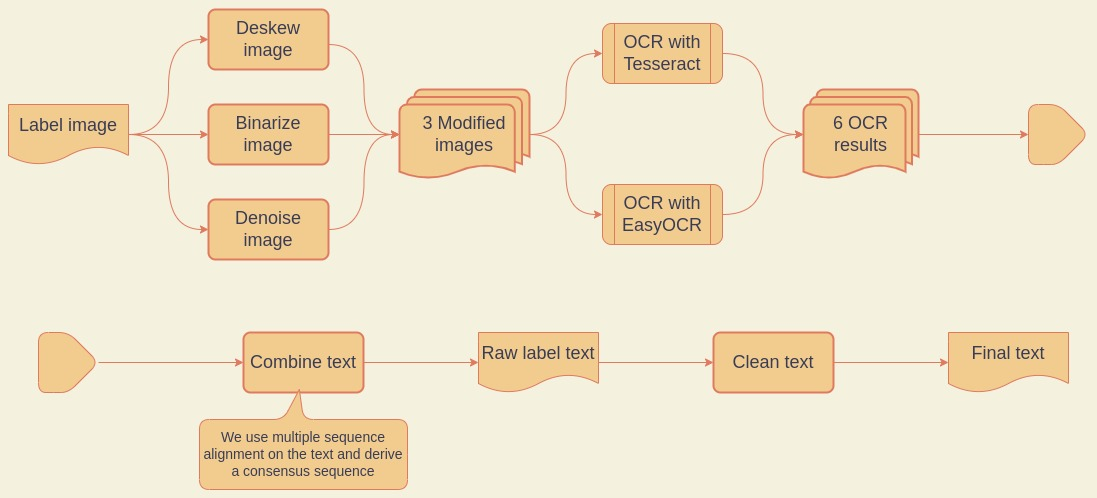

#### The are 4 steps to the full pipeline. The purpose of this notebook is to test if all of these steps really helps with the OCR results, and if they do, by how much.
1. Given a label image hit it with 3 processing pipelines that commonly improve OCR results.
    1. Deskew the image: It performs a gentle blur of the image, scales the image to an OCR friendly size, orients the image to be upright, and then it fine tunes the image orientation.
    1. Binarize the image: It does everything in the deskew pipeline and then it converts it to a black and white image using the Souvola algorithm.
    1. Denose the image: Does everything in binarize and then it tries to remove speckles and small holes by merging small islands of pixels with the surrounding values.
1. We take each modified image from step 1 and pass them thru 2 OCR engines yielding 6 sets of OCR results. Both engines have their advantages and disadvantages.
    1. Tesseract: This is the OCR engine most people are familiar with.
    1. EaasyOCR: A more recent OCR engine.
1. Now we combine the 6 sets of OCR results into 1 by doing:
    1. A multiple sequence alignment on the lines of text using a character "visual" similarity matrix for scoring replacements and gaps.
    1. We then derive a consensus sequence from that multiple sequence alignment.
1. Finally, we cleanup the text with various techniques.
    1. We use a spell checker to fix lingering misspelling.
    1. Replace common OCR character issues like mixing up or droping punctuation, etc.
    1. OCR engines have issues with spaces and we try to correct those by seeing if adding or removing them improves the text output.

## Comparison strategy

#### We're doing ablations on the OCR pipeline.
- How well do Tesseract and EasyOCR perform on their own?
- How well do each of the image processing steps (deskew, binarize, denoise) help the OCR process?
- Does the multiple sequence alignment (MSA) improve OCR results and do all image processing pipelines help with the MSA?
- How much does the text cleaning step help?

#### To score sequences we are using expert derived text as a gold standard and scoring the ablation results against the gold standard using Levenshtein distance.

## Setup

In [5]:
import sys

sys.path.append("..")

In [6]:
import sqlite3
import warnings
from pathlib import Path
from types import SimpleNamespace

import cppimport.import_hook  # noqa pylint: disable=unused-import
import pandas as pd
import pytesseract
from PIL import Image

from digi_leap.pylib import log
from digi_leap.pylib import consts
from digi_leap.pylib.db import db
from digi_leap.pylib.label_builder import label_builder
from digi_leap.pylib.label_builder.line_align import line_align_py  # noqa
from digi_leap.pylib.label_builder.line_align import line_align_subs
from digi_leap.pylib.label_builder.spell_well import spell_well as sw
from digi_leap.pylib.ocr import label_transformer
from digi_leap.pylib.ocr import ocr_runner

## Constants

In a command line module they would be arguments

In [ ]:
args = SimpleNamespace(
    database=Path(consts.DATA_DIR / "sernec" / "sernec.sqlite"),
    gold_set="first_gold_set",
    score_set="notebook_scores",
    notes="",
)